### ***Cricket Short Classification using CNN and Transfer Learning***

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [51]:
df=tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\User\Desktop\Projects\Cricket Short Classification using CNN\data",
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 4723 files belonging to 4 classes.


In [52]:
class_names=df.class_names
print(class_names)

['drive', 'legglance-flick', 'pullshot', 'sweep']


### ***Checking Some Images***

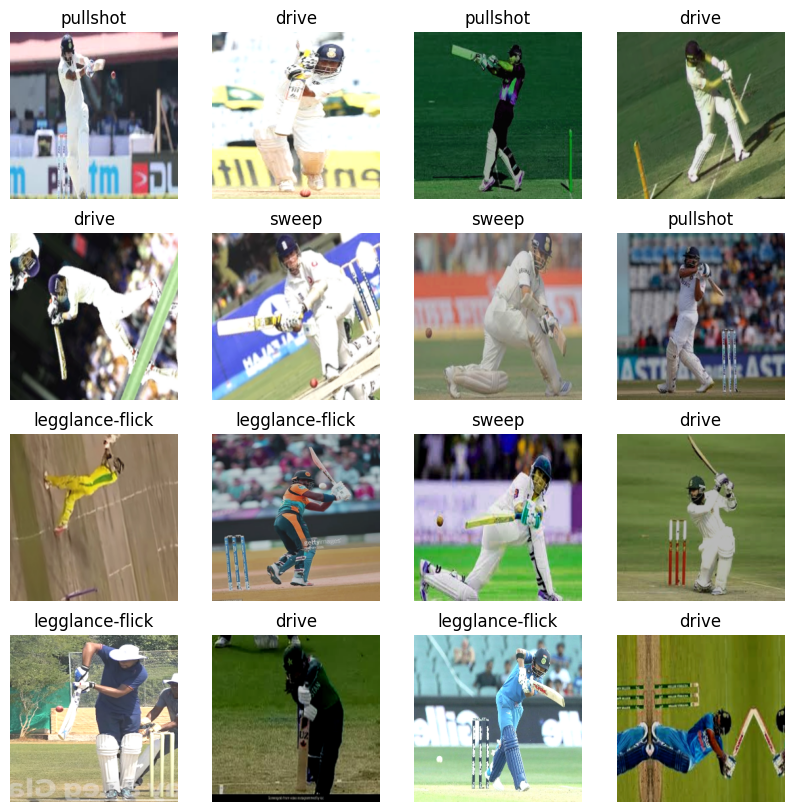

In [55]:
plt.figure(figsize=(10,10))
for images, labels in df.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### ***Splitting Dataset into Train/Dev/Test Set***

In [56]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [57]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [58]:
print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 118
Validation size: 14
Test size: 16


In [59]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### ***Data Normalization***

In [60]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255)
])

### ***Training my Own CNN model***

In [61]:
model = models.Sequential([
    layers.Input(shape=(256,256,3)),
    resize_and_rescale,

    layers.Conv2D(16,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(4,activation="softmax")
])


In [62]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,836 (2.77 MB)

 Trainable params: 724,836 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.compile(optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

In [64]:
history=model.fit(train_ds,
                validation_data=val_ds,
                batch_size=32,
                epochs=10)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 119s 877ms/step - accuracy: 0.4239 - loss: 1.2385 - val_accuracy: 0.5781 - val_loss: 1.0388
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 91s 768ms/step - accuracy: 0.6856 - loss: 0.8057 - val_accuracy: 0.8415 - val_loss: 0.5523
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 521ms/step - accuracy: 0.7991 - loss: 0.5318 - val_accuracy: 0.7857 - val_loss: 0.5596
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 495ms/step - accuracy: 0.8690 - loss: 0.3680 - val_accuracy: 0.9062 - val_loss: 0.2795
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 69s 585ms/step - accuracy: 0.9104 - loss: 0.2496 - val_accuracy: 0.9219 - val_loss: 0.2103
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 618ms/step - accuracy: 0.9471 - loss: 0.1541 - val_accuracy: 0.9643 - val_loss: 0.1162
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 704ms/step - accuracy: 0.9724 - loss: 0.0792 - val_accuracy: 0.9576 - val_loss: 0.1057
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 553ms/step - accuracy: 0.9811 - loss: 

In [65]:
model.evaluate(test_ds.skip(0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9863 - loss: 0.0775


[0.07752325385808945, 0.986328125]

In [18]:
model.evaluate(val_ds.skip(0))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9799 - loss: 0.0966


[0.09660842269659042, 0.9799107313156128]

### ***Transfer Learning using RestNet50***

In [25]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
model_resnet = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(4, activation="softmax")
])

In [26]:
model_resnet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [27]:
model_resnet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [28]:
history=model_resnet.fit(train_ds,
                validation_data=val_ds,
                batch_size=32,
                epochs=10)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.3258 - loss: 1.3890 - val_accuracy: 0.4263 - val_loss: 1.3322
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3550 - loss: 1.3390 - val_accuracy: 0.3371 - val_loss: 1.3282
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.3665 - loss: 1.3154 - val_accuracy: 0.4464 - val_loss: 1.2961
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.3707 - loss: 1.3052 - val_accuracy: 0.4263 - val_loss: 1.2811
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.3906 - loss: 1.2846 - val_accuracy: 0.4062 - val_loss: 1.2748
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.4061 - loss: 1.2720 - val_accuracy: 0.4308 - val_loss: 1.2557
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3986 - loss: 1.2708 - val_accuracy: 0.4308 - val_loss: 1.2421
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.4135 - loss: 1.2522 - val_accu

In [29]:
model_resnet.evaluate(test_ds.skip(0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4082 - loss: 1.2528


[1.2528319358825684, 0.408203125]

### ***Transfer Learning using MobilleNetV2***

In [ ]:
base_model=MobileNetV2(input_shape=(256,256,3), include_top=False, weights="imagenet")
base_model.trainable=False
model_mobilenet = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(4, activation="softmax")
])

C:\Users\User\AppData\Local\Temp\ipykernel_14576\3969682835.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNetV2(input_shape=(256,256,3), include_top=False, weights="imagenet")


In [31]:
model_mobilenet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [32]:
model_mobilenet.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
history_mobilenet=model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=10)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 94s 748ms/step - accuracy: 0.7805 - loss: 0.5995 - val_accuracy: 0.9174 - val_loss: 0.2559
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 90s 761ms/step - accuracy: 0.9535 - loss: 0.1734 - val_accuracy: 0.9777 - val_loss: 0.1115
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 702ms/step - accuracy: 0.9766 - loss: 0.0962 - val_accuracy: 0.9754 - val_loss: 0.0830
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 79s 672ms/step - accuracy: 0.9891 - loss: 0.0557 - val_accuracy: 0.9888 - val_loss: 0.0611
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 79s 673ms/step - accuracy: 0.9976 - loss: 0.0285 - val_accuracy: 0.9911 - val_loss: 0.0418
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 674ms/step - accuracy: 0.9997 - loss: 0.0151 - val_accuracy: 0.9933 - val_loss: 0.0357
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 643ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.9933 - val_loss: 0.0348
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 79s 668ms/step - accuracy: 1.0000 - loss: 0

In [34]:
model_mobilenet.evaluate(test_ds.skip(0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 664ms/step - accuracy: 0.9961 - loss: 0.0163


[0.016322491690516472, 0.99609375]

#### ***The model appears to exhibit slight overfitting. To mitigate this, we will employ regularization techniques such as Dropout and Early Stopping. Data augmentation will not be applied, as the dataset provider has already performed it; introducing additional augmentation may negatively impact model performance.***

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256,256,3),  
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model_mobilenet = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Dense(4, activation="softmax")
])

C:\Users\User\AppData\Local\Temp\ipykernel_14576\2720304677.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [69]:
model_mobilenet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [71]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [ ]:
model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    callbacks=[early_stop]
)

In [ ]:
model_mobilenet.evaluate(test_ds.skip(0))

In [ ]:
model_mobilenet.evaluate(val_ds.skip(0))

### ***Plotting Model History***

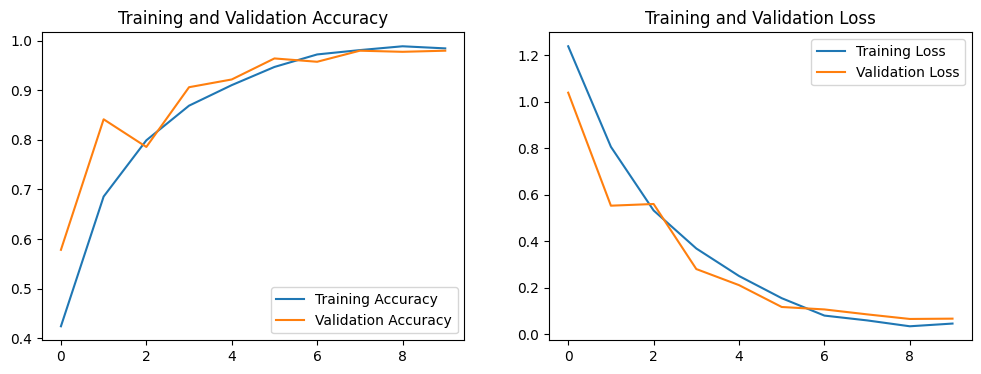

In [73]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(len(acc))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


First Image To Predict
Actual Label: legglance-flick
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicted Label is: legglance-flick


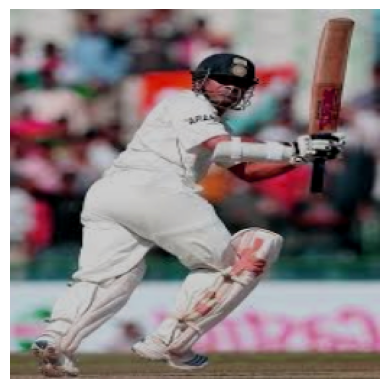

In [45]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0]
    print("First Image To Predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual Label:",class_names[first_label])
    batch_prediction=model_mobilenet.predict(images_batch)
    print("Predicted Label is:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model_mobilenet,img):
    img_array=tf.expand_dims(img,0)
    predictions=model_mobilenet.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


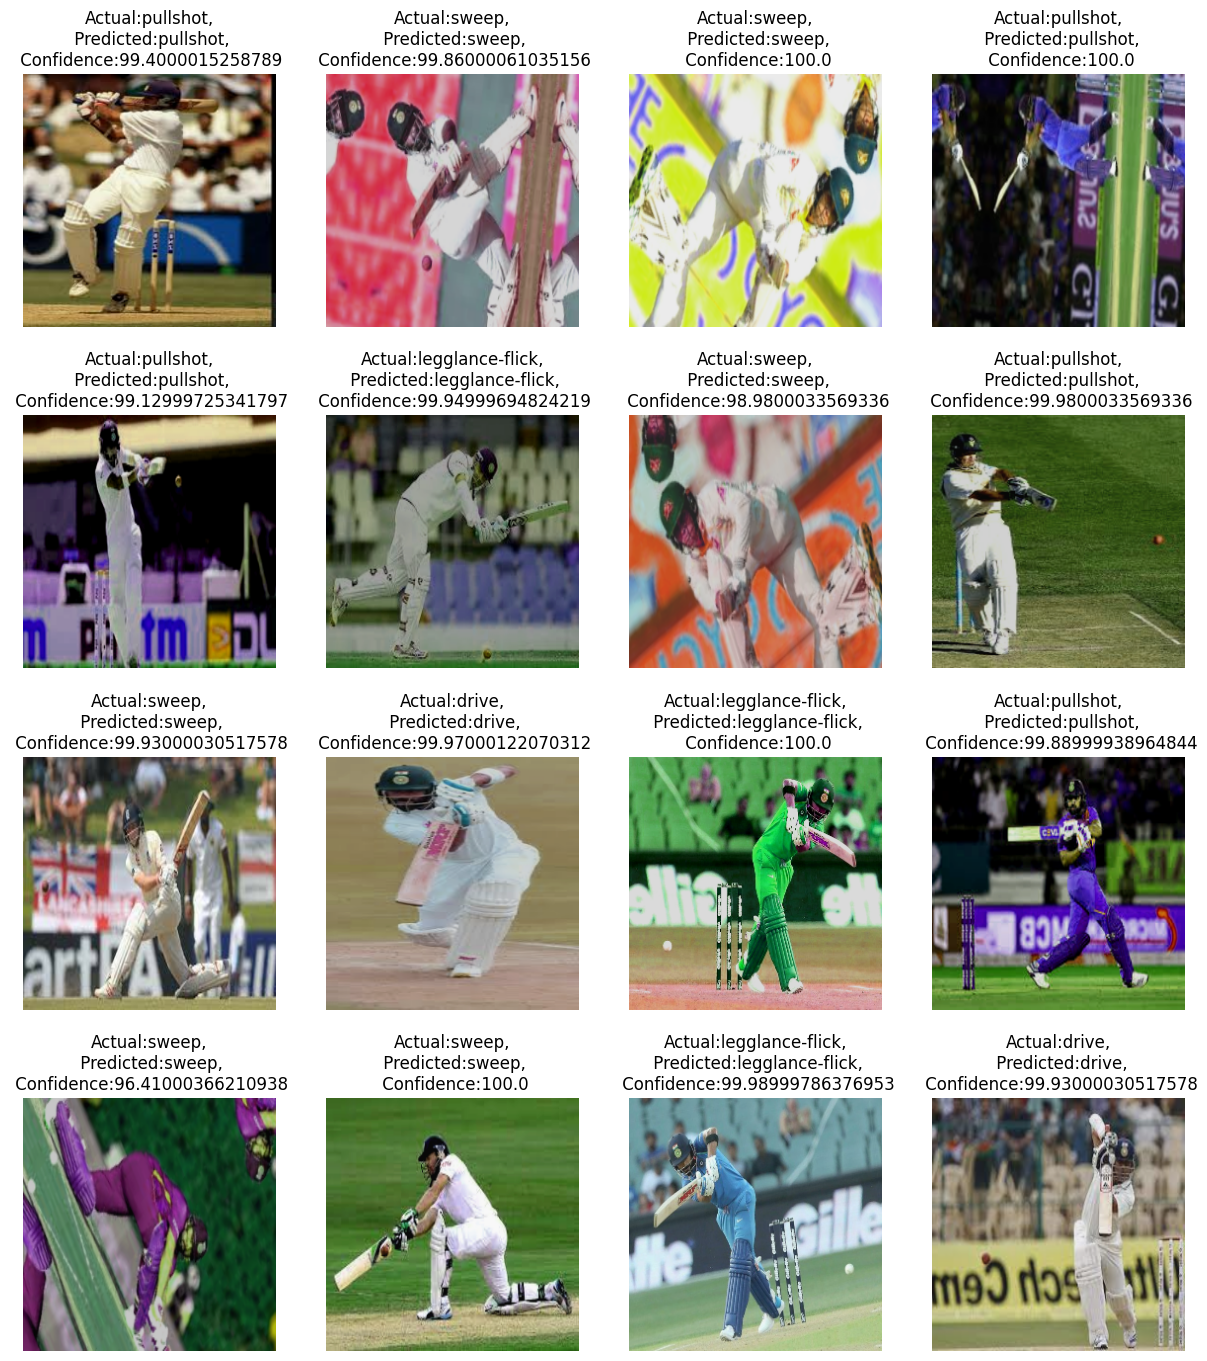

In [49]:
plt.figure(figsize=(15,17))
for images,labels in train_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model_mobilenet,images[i].numpy().astype("uint8"))
        actual_class=class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")

        plt.axis("off")

### ***Saving All Models***

In [74]:
model.save("custom.keras")
model_mobilenet.save("mobilenetv2.keras")
model_resnet.save("resnet50.keras")